# 서울시 코로나19 확진자 현황

In [1]:
import sys
import numpy as np
import pandas as pd
import time
import json
import re

# A Fast, Extensible Progress Bar for Python and CLI
from tqdm import tqdm

In [ ]:
# Statistical data visualization using matplotlib.
import seaborn as sns

# matplotlib: plotting with Python.
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager

# Set the matplotlib color cycle using a seaborn palette.
sns.set_palette('pastel')

# plot outputs appear and be stored within the notebook.
%matplotlib inline

# A module for finding, managing, and using fonts across platforms.
mpl.font_manager._rebuild()
sorted([f.name for f in mpl.font_manager.fontManager.ttflist if f.name.startswith('Malgun')])

mpl.rc('axes', unicode_minus=False)

if sys.platform.startswith('darwin'):
    mpl.rc('font', family='AppleGothic')
elif sys.platform.startswith('win32'):
    mpl.rc('font', family='Malgun Gothic')

In [ ]:
# Python Data. Leaflet.js Maps.
import folium

In [ ]:
# An importlib package installable from any python version
import importlib
import modules.fs as fs
import modules.folium as fo

## 지역구 인구

In [2]:
korea = fs.read_csv('./data/population_202010.csv')
seoul = korea[korea['시도명'] == '서울특별시']
seoul.head(1)

,시도명,시도코드,시군구명,시군구코드,인구수,남자수,여자수,시군구_x,시군구_y
0,서울특별시,11,종로구,11110,151290,73746,77544,954859.306142,1.953755e+06


## 지역구 분석

In [3]:
# 상태 분석
gu_status = fs.read_csv('./data/gu_status.csv')
gu_status.rename(columns={'Unnamed: 0': '시군구명'}, inplace=True)
gu_status.set_index('시군구명', inplace=True)
gu_status.head(1)

,퇴원,사망,입원
시군구명,,,
강남구,390.0,4.0,126.0


In [4]:
# 여행력 분석
gu_travel = fs.read_csv('./data/gu_travel.csv')
gu_travel.rename(columns={'Unnamed: 0': '시군구명'}, inplace=True)
gu_travel.set_index('시군구명', inplace=True)
gu_travel.head(1)

,집,여행
시군구명,,
강남구,464,56.0


In [5]:
# 감염률 분석
gu_data = pd.merge(gu_status, gu_travel, on='시군구명')
gu_data = pd.merge(seoul, gu_data, on='시군구명')

gu_data.fillna(0, inplace=True)

gu_data['SIG_CD'] = gu_data['시군구코드'].astype(str)
gu_data['확진자'] = gu_data['입원'] + gu_data['퇴원'] + gu_data['사망']
gu_data['인구감염률'] = gu_data['확진자'] / gu_data['인구수'] * 100

gu_data.head()

,시도명,시도코드,시군구명,시군구코드,인구수,남자수,여자수,시군구_x,시군구_y,퇴원,사망,입원,집,여행,SIG_CD,확진자,인구감염률
0,서울특별시,11,종로구,11110,151290,73746,77544,954859.306142,1.953755e+06,99.0,1.0,26.0,113,13.0,11110,126.0,0.083284
1,서울특별시,11,중구,11140,126171,61910,64261,955931.027850,1.951526e+06,80.0,1.0,29.0,101,9.0,11140,110.0,0.087183
2,서울특별시,11,용산구,11170,228670,110356,118314,954122.014984,1.948855e+06,165.0,0.0,0.0,184,42.0,11170,165.0,0.072156
3,서울특별시,11,성동구,11200,300889,147273,153616,959571.250766,1.950601e+06,167.0,3.0,53.0,203,20.0,11200,223.0,0.074114
4,서울특별시,11,광진구,11215,351350,170262,181088,963032.466631,1.949996e+06,147.0,4.0,35.0,179,7.0,11215,186.0,0.052939


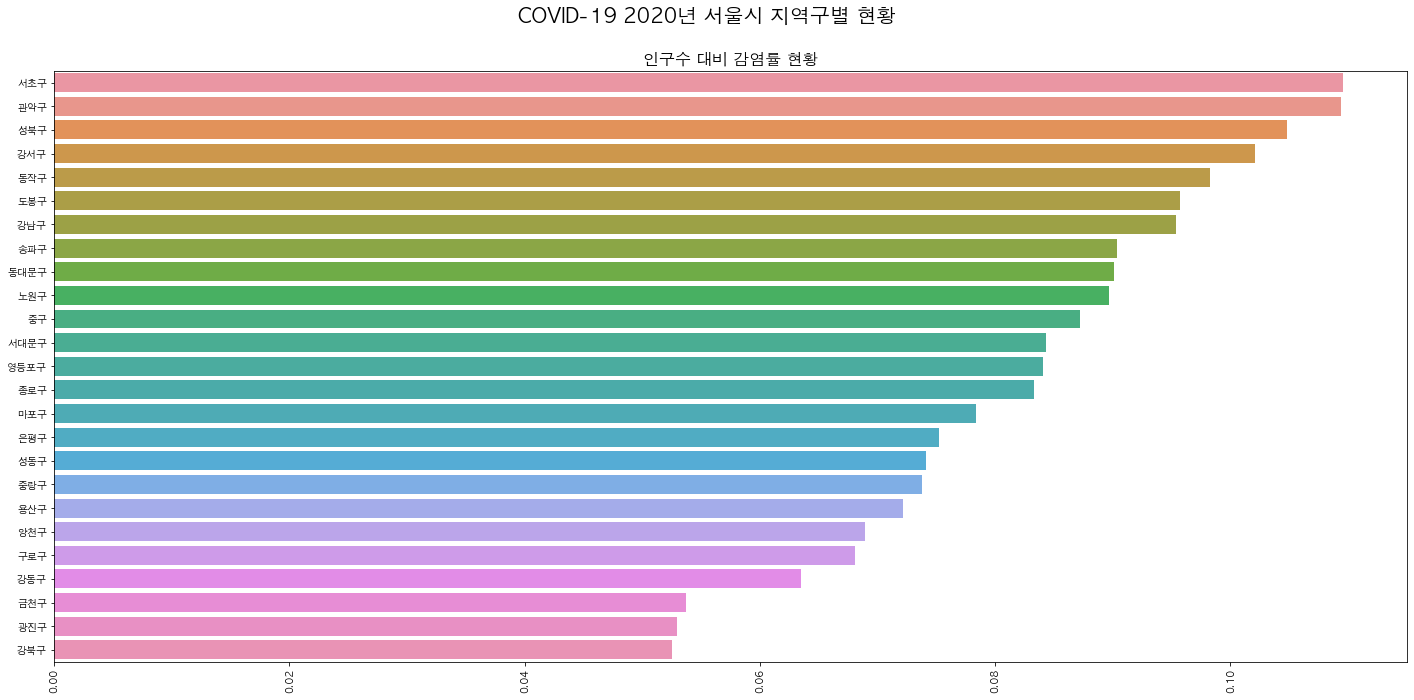

In [6]:
fig = plt.figure(figsize=(20, 10))

# 감염률: 인구
ax1 = plt.subplot(1, 1, 1)
ax1.tick_params(axis='x', rotation=90)

sns.barplot(x='인구감염률', y='시군구명', data=gu_data.sort_values(by='인구감염률', ascending=False))

ax1.set_title('인구수 대비 감염률 현황', fontsize=16, fontweight='bold')
ax1.set(xlabel=None, ylabel=None)

# 설정
fig.suptitle('COVID-19 2020년 서울시 지역구별 현황', fontsize=20, fontweight='bold')
fig.tight_layout(pad=2)

# 출력
plt.savefig('./assets/img/covid19_rate.png', format='png', dpi=300)
plt.show()

## 그래프 시각화

In [9]:
geo_data = json.load(open('./assets/json/02.skorea_municipalities_geo_simple.json', encoding='utf8'))

m1 = folium.Map(
    location=[37.5502, 126.982], 
    tiles='cartodbpositron', # Stamen Toner, cartodbpositron
    zoom_start=11
)

m1.choropleth(
    name='choropleth',
    geo_data=geo_data, 
    data=gu_data, 
    fill_color='OrRd', # black, BuGn, BuPu, GnBu, OrRd, PuBu, PuBuGn, PuRd, RdPu, YlGn, YlGnBu, YlOrBr, and YlOrRd.
    columns=['시군구명', '확진자'], 
    key_on='properties.name'
)

m1.save('./assets/img/covid19_seoul_map.html')
m1

In [ ]:
fo.save_screenshot(
    htmlPath='file:///Users/junhyun/Documents/workspace/shoseo/Data-Analysis-2020/09.Covid19/covid19-seoul-map.html', 
    imgPath='./assets/img/covid19_seoul_map.png'
)